In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import sys
import time

## Config

In [3]:
config = {
 'spark_modules_path'     : '../',
 'data_base_path'         : '/FileStore/tables/vacation_data/',
 'data_ptnd_base_path'    : '/FileStore/tables/vacation_partitioned/',
 'call_data_path'         : 'dial_summary.parquet',
 'last_activity_data_path': 'customer_activity.parquet',
 'booking_data_path'      : 'class_labels.parquet',
 'consumer_data_path'     : 'customer.parquet',
 'web_data_path'          : {
                          'path1': 'itr_data_1.parquet',
                          'path2': 'itr_data_2.parquet'
                            },   
 'current_date'           : '2019-04-26',
 'prediction_days'        : 90,
 'filesystem'             : 'dbfs',
 'spark_config'           : {} #{'spark.executor.cores':'3','spark.cores.max':'3'}
}

In [4]:
sys.path.append(f"{config['spark_modules_path']}")
pd.set_option('display.max_columns', None)

In [5]:
!pip install pyspark-dist-explore
!pip install hvplot
!pip install cytoolz

# Imports

In [6]:
%%time
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import types as DT
from pyspark.sql import functions as F

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoderEstimator, Imputer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from IPython.display import display,display_html

import pyspark

import holoviews as hv
import hvplot

import panel as pn
pn.extension('bokeh')

import dp
import features
import model_gen
import model_eval
import utils
import eda

import context

from pyspark.sql import Window
import re
import random
import time
random.seed(0)

Wall time: 10.1 s


# Create Spark Session

In [7]:
%%time
spark_object = context.SparkSession(config)
spark_object.CreateSparkSession(appName="celebrity")

spark = spark_object.spark
sc = spark_object.sc

Wall time: 27.3 s


In [8]:
spark

<u><b><i>Spark config</i></b></u>

In [9]:
spark_object.scConf.getAll()

[('spark.driver.host', 'TIGER0332.tigeranalytics.local'),
 ('spark.app.name', 'celebrity'),
 ('spark.sql.warehouse.dir',
  'file:/C:/Users/amrit.bhaskar/Documents/code-templates/scripts/spark/case_examples/spark-warehouse'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1599636682636'),
 ('spark.driver.port', '53215'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# DATA READ

## Dev NOTES
Usage of s3 Filesystem is recommended

In [10]:
df_call_data = dp.read_data(spark=spark, paths=[config['data_ptnd_base_path'] + config['call_data_path']], fs=config['filesystem'], fmt="parquet", header="true", inferschema="true")
df_call_data.printSchema()

root
 |-- originatingnumber: long (nullable = true)
 |-- dialednumber: long (nullable = true)
 |-- call_date: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- cel_class_code: string (nullable = true)
 |-- unq_add: string (nullable = true)
 |-- customer_id: long (nullable = true)



In [11]:
df_last_activity_data = dp.read_data(spark=spark, paths=[config['data_ptnd_base_path'] + config['last_activity_data_path']], fs=config['filesystem'], fmt="parquet", header="true", inferschema="true")
df_last_activity_data.printSchema()

root
 |-- load_date: string (nullable = true)
 |-- consumer_first_name: string (nullable = true)
 |-- consumer_last_name: string (nullable = true)
 |-- email_address: string (nullable = true)
 |-- cel_email_permission_flag: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- cel_class_code: string (nullable = true)
 |-- actvty_date: string (nullable = true)
 |-- actvty_type: string (nullable = true)
 |-- actvty_prod: string (nullable = true)
 |-- customer_id: long (nullable = true)



In [12]:
df_booking_data = dp.read_data(spark=spark, paths=[config['data_ptnd_base_path'] + config['booking_data_path']], fs=config['filesystem'], fmt="parquet", header="true", inferschema="true")
df_booking_data.printSchema()

root
 |-- booking_create_date: string (nullable = true)
 |-- booking_status_bk_level: string (nullable = true)
 |-- sailing_date: string (nullable = true)
 |-- curr_number_sail_nights: long (nullable = true)
 |-- meta_product_code: string (nullable = true)
 |-- cabin_class_sailed: string (nullable = true)
 |-- booking_channel: string (nullable = true)
 |-- choice_air_flag: string (nullable = true)
 |-- cruise_care_flag: string (nullable = true)
 |-- age: long (nullable = true)
 |-- gender_code: string (nullable = true)
 |-- dma: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- tier_at_sail: string (nullable = true)
 |-- family_flag_booking_level: string (nullable = true)
 |-- cel_class_code_sail: string (nullable = true)
 |-- customer_id: long (nullable = true)



In [13]:
df_consumer_data = dp.read_data(spark=spark, paths=[config['data_ptnd_base_path'] + config['consumer_data_path']], fs=config['filesystem'], fmt="parquet", header="true", inferschema="true")
df_booking_data.printSchema()

root
 |-- booking_create_date: string (nullable = true)
 |-- booking_status_bk_level: string (nullable = true)
 |-- sailing_date: string (nullable = true)
 |-- curr_number_sail_nights: long (nullable = true)
 |-- meta_product_code: string (nullable = true)
 |-- cabin_class_sailed: string (nullable = true)
 |-- booking_channel: string (nullable = true)
 |-- choice_air_flag: string (nullable = true)
 |-- cruise_care_flag: string (nullable = true)
 |-- age: long (nullable = true)
 |-- gender_code: string (nullable = true)
 |-- dma: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- tier_at_sail: string (nullable = true)
 |-- family_flag_booking_level: string (nullable = true)
 |-- cel_class_code_sail: string (nullable = true)
 |-- customer_id: long (nullable = true)



In [14]:
df_web_data = dp.read_data(spark=spark, paths=[config['data_ptnd_base_path'] + config['web_data_path']['path1']],
                        fs=config['filesystem'], fmt="parquet", header="true", inferschema="true")
df_web_data.printSchema()

root
 |-- visit_date: string (nullable = true)
 |-- visit_yr: integer (nullable = true)
 |-- visit_mo: integer (nullable = true)
 |-- device_type_name: string (nullable = true)
 |-- sec_time_spent_on_nbr: integer (nullable = true)
 |-- page_view_count: integer (nullable = true)
 |-- geo_seg_country_name: string (nullable = true)
 |-- visit_type: string (nullable = true)
 |-- customer_id: long (nullable = true)



## Sampling Dataset

Choose current_date post which we will predict the customer had made the booking in next 3 months.<br>
Filter all Feature dataset on the <i>current date</i>.<br>
Filter target dataset on <i>Prediction start date</i> and <i>Prediction end date</i>

In [15]:
current_date = pd.to_datetime(config['current_date'])
pred_start_date = current_date + pd.Timedelta(days=1)
pred_end_date = current_date + pd.Timedelta(days=config['prediction_days'])

print(f"Current date: {current_date} \t Prediction start date: {pred_start_date} \t Prediction end date: {pred_end_date} ")

Current date: 2019-04-26 00:00:00 	 Prediction start date: 2019-04-27 00:00:00 	 Prediction end date: 2019-07-25 00:00:00 


In [16]:
### Filter call_data dataframe
df_call_data = df_call_data.withColumn(
    'call_date', 
    F.to_date(F.unix_timestamp(F.col("call_date"), "ddMMMyyyy:HH:mm:ss").cast("timestamp"))
)
df_call_data = df_call_data.filter(F.col('call_date')<=current_date)

### Filter last_activity dataframe
df_last_activity_data = df_last_activity_data.dropDuplicates(['customer_id','actvty_date','actvty_type','actvty_prod'])
last_activity_date_cols = ['load_date','actvty_date']
for col in last_activity_date_cols:
    df_last_activity_data = df_last_activity_data.withColumn(
        col, 
        F.to_date(F.unix_timestamp(F.col(col), "ddMMMyyyy:HH:mm:ss").cast("timestamp"))
    )
df_last_activity_data = df_last_activity_data.filter(F.col('actvty_date')<=current_date)

### Filter web_data dataframe
df_web_data = df_web_data.dropDuplicates(['customer_id','visit_date','device_type_name','visit_type'])
df_web_data = df_web_data.withColumn(
    'visit_date', 
    F.to_date(F.unix_timestamp(F.col("visit_date"), "ddMMMyyyy:HH:mm:ss").cast("timestamp"))
)
df_web_data = df_web_data.filter(F.col('visit_date')<=current_date)

### Filter consumer_data dataframe
drop_lst = ['click_pct',
           'open_pct',
           'max_event_date',
           'booked_flag']
df_consumer_data = df_consumer_data.drop(*drop_lst)
df_consumer_data = df_consumer_data.withColumn(
    'cel_first_cruise_date', 
    F.to_date(F.unix_timestamp(F.col("cel_first_cruise_date"), "ddMMMyyyy:HH:mm:ss").cast("timestamp"))
)
df_consumer_data = df_consumer_data.filter(F.col('cel_first_cruise_date')<=current_date)

### Filter booking_data dataframe
df_booking_data = df_booking_data.withColumn(
    'booking_create_date',
    F.to_date(F.unix_timestamp(F.col("booking_create_date"), "ddMMMyyyy:HH:mm:ss").cast("timestamp"))
)
df_booking_data = df_booking_data.filter((F.col('booking_create_date') >= pred_start_date) \
                                        & (F.col('booking_create_date') <= pred_end_date))
df_booking_data = df_booking_data.select('customer_id')\
                                .dropDuplicates()\
                                .withColumn('target_var',F.lit(1))

Find number of common consumers across all feature tables.<br>
Then sample the data on the basis of target labels.

In [17]:
%%time
df_common_consumer = df_consumer_data.select('customer_id')\
                                    .join(df_call_data.select("customer_id"), on ='customer_id',how='inner')\
                                    .join(df_web_data.select("customer_id"), on='customer_id', how='inner')\
                                    .join(df_last_activity_data.select("customer_id"), on='customer_id', how='inner')\
                                    .dropDuplicates()
print(f"Total number of common consumers in all feature tables\t: {df_common_consumer.count()}")

### Map with target labels
df_common_consumer_booking = df_common_consumer.join(df_booking_data, on='customer_id', how='left')\
                                            .dropDuplicates()\
                                            .fillna(0, subset=['target_var'])

### Get the size of each class. To be used in sampling
booked_size = df_common_consumer_booking.filter(F.col('target_var')==1).count()
non_booked_size = df_common_consumer_booking.filter(F.col('target_var')==0).count()

print(f"Booked size\t: {booked_size}")
print(f"Non booked size\t: {non_booked_size}")

Total number of common consumers in all feature tables	: 106530
Booked size	: 13033
Non booked size	: 93497
Wall time: 3min 43s


Sample booking and non-booking customers to reduce the dataset

In [18]:
%%time
sample_num_rows_0 = 500 #booked_size*3
sample_num_rows_1 = 500 #booked_size

df_sampled_booking = df_common_consumer_booking.sampleBy("target_var", fractions={0: (sample_num_rows_0/non_booked_size)
                                                                                , 1: (sample_num_rows_1/booked_size)} ,seed=42)
df_sampled_booking = df_sampled_booking.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
# print(f"Total number of rows sampled\t: {df_sampled_booking.count()}")

#df_sampled_booking = df_common_consumer_booking

Wall time: 4.07 s


In [19]:
%%time
consumer_sampled = df_sampled_booking.select("customer_id").rdd.flatMap(lambda x: x).collect()
# print(f"Distinct number of customers sampled\t: {len(consumer_sampled)}")

Wall time: 31.1 s


In [20]:
%%time
consumer_sampled_bd = sc.broadcast(consumer_sampled)
df_consumer_data = df_consumer_data.filter(F.col('customer_id').isin(consumer_sampled_bd.value))
df_call_data = df_call_data.filter(F.col('customer_id').isin(consumer_sampled_bd.value))
df_web_data = df_web_data.filter(F.col('customer_id').isin(consumer_sampled_bd.value))
df_last_activity_data = df_last_activity_data.filter(F.col('customer_id').isin(consumer_sampled_bd.value))

# print(df_consumer_data.count(), df_call_data.count(), df_web_data.count(), df_last_activity_data.count())

Wall time: 18.1 s


# Identification of columns types in the data

In [21]:
%%time
num_cols = dp._list_numerical_columns(df_call_data)
cat_cols = dp._list_categorical_columns(df_call_data)   
bool_cols = dp._list_boolean_columns(df_call_data)
date_cols = dp._list_datelike_columns(df_call_data)
num_cols, cat_cols, bool_cols, date_cols

Wall time: 12.4 ms


(['originatingnumber', 'dialednumber', 'customer_id'],
 ['country_code', 'cel_class_code', 'unq_add'],
 [],
 ['call_date'])

In [22]:
num_cols = dp._list_numerical_columns(df_sampled_booking)
cat_cols = dp._list_categorical_columns(df_sampled_booking)   
bool_cols = dp._list_boolean_columns(df_sampled_booking)
date_cols = dp._list_datelike_columns(df_sampled_booking)
num_cols, cat_cols, bool_cols, date_cols

(['customer_id', 'target_var'], [], [], [])

In [23]:
num_cols = dp._list_numerical_columns(df_last_activity_data)
cat_cols = dp._list_categorical_columns(df_last_activity_data)   
bool_cols = dp._list_boolean_columns(df_last_activity_data)
date_cols = dp._list_datelike_columns(df_last_activity_data)
num_cols, cat_cols, bool_cols, date_cols

(['customer_id'],
 ['consumer_first_name',
  'consumer_last_name',
  'email_address',
  'cel_email_permission_flag',
  'country_code',
  'state_code',
  'cel_class_code',
  'actvty_type',
  'actvty_prod'],
 [],
 ['load_date', 'actvty_date'])

In [24]:
num_cols = dp._list_numerical_columns(df_web_data)
cat_cols = dp._list_categorical_columns(df_web_data)   
bool_cols = dp._list_boolean_columns(df_web_data)
date_cols = dp._list_datelike_columns(df_web_data)
num_cols, cat_cols, bool_cols, date_cols

(['visit_yr',
  'visit_mo',
  'sec_time_spent_on_nbr',
  'page_view_count',
  'customer_id'],
 ['device_type_name', 'geo_seg_country_name', 'visit_type'],
 [],
 ['visit_date'])

In [25]:
num_cols = dp._list_numerical_columns(df_consumer_data)
cat_cols = dp._list_categorical_columns(df_consumer_data)   
bool_cols = dp._list_boolean_columns(df_consumer_data)
date_cols = dp._list_datelike_columns(df_consumer_data)
num_cols, cat_cols, bool_cols, date_cols

(['age',
  'last_cruise_months_ago',
  'click_to_open',
  'beach_relax_cruise_intention',
  'luxury_relax_cruise_intention',
  'natural_wonders_cruise_intenti',
  'new_metro_cruise_intention',
  'old_metro_cruise_intention',
  'sea_cruise_intention',
  'town_cruise_intention',
  'rci_qualify_cruise_qty',
  'customer_id'],
 ['cel_class_code',
  'rci_class_code',
  'aza_class_code',
  'high_value_zip_desc',
  'et_active_flag',
  'jm_hml_segment_code',
  'cel_dma_desc',
  'cc_current_loyalty_tier_code',
  'gender_code',
  'state_code'],
 [],
 ['cel_first_cruise_date'])

# Check column data consistency

In [26]:
%%time
dp.check_column_data_consistency(df_call_data)

No inconsistency in data
Wall time: 16.1 s


In [27]:
%%time
dp.check_column_data_consistency(df_last_activity_data)

No inconsistency in data
Wall time: 49.7 s


In [28]:
%%time
dp.check_column_data_consistency(df_sampled_booking)

No inconsistency in data
Wall time: 4.31 ms


In [29]:
%%time
dp.check_column_data_consistency(df_consumer_data)

No inconsistency in data
Wall time: 36.9 s


In [30]:
%%time
dp.check_column_data_consistency(df_web_data)

No inconsistency in data
Wall time: 38.7 s


# Clean Columns in the data

In [31]:
df_call_data = dp._clean_columns(df_call_data)

In [32]:
df_last_activity_data = dp._clean_columns(df_last_activity_data)

In [33]:
df_booking_data = dp._clean_columns(df_sampled_booking)

In [34]:
df_consumer_data = dp._clean_columns(df_consumer_data)

In [35]:
df_web_data = dp._clean_columns(df_web_data)

# Columns Spec Summary

In [36]:
%%time
col_smry_1 = eda._column_values_summary(df_consumer_data)
col_smry_1

Wall time: 8.46 s


age cel_class_code rci_class_code  \
data type             IntegerType     StringType     StringType   
distinct count                 67              1              3   
distinct count(perc)         6.69            0.1            0.3   

                     aza_class_code high_value_zip_desc et_active_flag  \
data type                StringType          StringType     StringType   
distinct count                    3                   4              4   
distinct count(perc)            0.3                 0.4            0.4   

                     jm_hml_segment_code last_cruise_months_ago click_to_open  \
data type                     StringType             DoubleType    DoubleType   
distinct count                         5                    489            75   
distinct count(perc)                 0.5                   48.8          7.49   

                     cel_dma_desc cel_first_cruise_date  \
data type              StringType              DateType   
distinct count                110                   823   
distinct count(perc)        10.98                 82.14   

                     cc_current_loyalty_tier_code  \
data type                              StringType   
distinct count                                  5   
distinct count(perc)                          0.5   

                     beach_relax_cruise_intention  \
data type                              DoubleType   
distinct count                                  7   
distinct count(perc)                          0.7   

                     luxury_relax_cruise_intention  \
data type                               DoubleType   
distinct count                                   6   
distinct count(perc)                           0.6   

                     natural_wonders_cruise_intenti  \
data type                                DoubleType   
distinct count                                    6   
distinct count(perc)                            0.6   

                     new_metro_cruise_intention old_metro_cruise_intention  \
data type                            DoubleType                 DoubleType   
distinct count                                6                          7   
distinct count(perc)                        0.6                        0.7   

                     sea_cruise_intention town_cruise_intention gender_code  \
data type                      DoubleType            DoubleType  StringType   
distinct count                          5                     4           2   
distinct count(perc)                  0.5                   0.4         0.2   

                      state_code rci_qualify_cruise_qty customer_id  
data type             StringType            IntegerType    LongType  
distinct count                48                     30        1002  
distinct count(perc)        4.79                   2.99         100

In [37]:
%%time
col_smry_2 = eda._column_values_summary(df_call_data)
col_smry_2

Wall time: 7.62 s


originatingnumber dialednumber call_date country_code  \
data type                     LongType     LongType  DateType   StringType   
distinct count                    1068           39       921            2   
distinct count(perc)             14.73         0.54      12.7         0.03   

                     cel_class_code     unq_add customer_id  
data type                StringType  StringType    LongType  
distinct count                    1         998        1002  
distinct count(perc)           0.01       13.76       13.82

In [38]:
%%time
col_smry_3 = eda._column_values_summary(df_last_activity_data)
col_smry_3

Wall time: 10 s


load_date consumer_first_name consumer_last_name  \
data type             DateType          StringType         StringType   
distinct count               1                 476                907   
distinct count(perc)      0.03               16.06              30.61   

                     email_address cel_email_permission_flag country_code  \
data type               StringType                StringType   StringType   
distinct count                1000                         3            2   
distinct count(perc)         33.75                       0.1         0.07   

                      state_code cel_class_code actvty_date actvty_type  \
data type             StringType     StringType    DateType  StringType   
distinct count                51              1        1065           5   
distinct count(perc)        1.72           0.03       35.94        0.17   

                     actvty_prod customer_id  
data type             StringType    LongType  
distinct count                22        1002  
distinct count(perc)        0.74       33.82

In [39]:
%%time
col_smry_4 = eda._column_values_summary(df_sampled_booking)
col_smry_4

Wall time: 5.74 s


customer_id   target_var
data type               LongType  IntegerType
distinct count              1002            2
distinct count(perc)         100          0.2

In [40]:
%%time
col_smry_5 = eda._column_values_summary(df_web_data)
col_smry_5

Wall time: 27.6 s


visit_date     visit_yr     visit_mo device_type_name  \
data type              DateType  IntegerType  IntegerType       StringType   
distinct count             1585            5           12                3   
distinct count(perc)       3.06         0.01         0.02             0.01   

                     sec_time_spent_on_nbr page_view_count  \
data type                      IntegerType     IntegerType   
distinct count                        3604             142   
distinct count(perc)                  6.96            0.27   

                     geo_seg_country_name  visit_type customer_id  
data type                      StringType  StringType    LongType  
distinct count                          2          31        1002  
distinct count(perc)                    0        0.06        1.94

# Identification of Missing Values

In [41]:
%%time
# print(df_call_data.count())
dp.identify_missing_values(df_call_data).toPandas()

Wall time: 5.04 s


originatingnumber  dialednumber  call_date  country_code  cel_class_code  \
0                  0             0          0             4               0   

   unq_add  customer_id  
0        0            0

In [42]:
%%time
# print(df_last_activity_data.count())
dp.identify_missing_values(df_last_activity_data).toPandas()

Wall time: 5.22 s


load_date  consumer_first_name  consumer_last_name  email_address  \
0          0                    0                   0              0   

   cel_email_permission_flag  country_code  state_code  cel_class_code  \
0                          0             1         402               0   

   actvty_date  actvty_type  actvty_prod  customer_id  
0            0            0            0            0

In [43]:
%%time
# print(df_sampled_booking.count())
dp.identify_missing_values(df_sampled_booking).toPandas()

Wall time: 3.12 s


customer_id  target_var
0            0           0

In [44]:
%%time
# print(df_web_data.count())
dp.identify_missing_values(df_web_data).toPandas()

Wall time: 14.1 s


visit_date  visit_yr  visit_mo  device_type_name  sec_time_spent_on_nbr  \
0           0         0         0                 0                      0   

   page_view_count  geo_seg_country_name  visit_type  customer_id  
0                0                     0           0            0

In [45]:
%%time
# print(df_consumer_data.count())
dp.identify_missing_values(df_consumer_data).toPandas()

Wall time: 4.74 s


age  cel_class_code  rci_class_code  aza_class_code  high_value_zip_desc  \
0    0               0               0               0                  603   

   et_active_flag  jm_hml_segment_code  last_cruise_months_ago  click_to_open  \
0               4                    8                       0            378   

   cel_dma_desc  cel_first_cruise_date  cc_current_loyalty_tier_code  \
0           130                      0                            27   

   beach_relax_cruise_intention  luxury_relax_cruise_intention  \
0                           104                            751   

   natural_wonders_cruise_intenti  new_metro_cruise_intention  \
0                             293                         138   

   old_metro_cruise_intention  sea_cruise_intention  town_cruise_intention  \
0                         414                    36                    786   

   gender_code  state_code  rci_qualify_cruise_qty  customer_id  
0            0         124                       0            0

# EDA

## Health Analysis

This tells about

1. percentage of Numeric variables and other variables

2. %age of missing values

3. %age of duplicated rows

In [46]:
%%time
health_plot_df_call=eda.plot_health(df_call_data)
pn.panel(health_plot_df_call)

Wall time: 11.3 s


HoloViews(Layout)

In [47]:
%%time
health_plot_df_last_activity_info=eda.plot_health(df_last_activity_data)
pn.panel(health_plot_df_last_activity_info)

Wall time: 11.7 s


HoloViews(Layout)

In [48]:
%%time
health_plot_df_booking_info=eda.plot_health(df_sampled_booking)
pn.panel(health_plot_df_booking_info)

Wall time: 5.82 s


HoloViews(Layout)

In [49]:
%%time
health_plot_df_web_data_info=eda.plot_health(df_web_data)
pn.panel(health_plot_df_web_data_info)

Wall time: 37.6 s


HoloViews(Layout)

In [50]:
%%time
health_plot_df_consumer_data=eda.plot_health(df_consumer_data)
pn.panel(health_plot_df_consumer_data)

Wall time: 9.87 s


HoloViews(Layout)

# Missing Plot

In [51]:
%%time
missing_value_plot_df_call_info = eda.missing_plot(df_call_data)
pn.panel(missing_value_plot_df_call_info)

Wall time: 7.66 s


HoloViews(Bars)

In [52]:
%%time
missing_value_plot_df_last_activity_info = eda.missing_plot(df_last_activity_data)
pn.panel(missing_value_plot_df_last_activity_info)

Wall time: 7.63 s


HoloViews(Bars)

In [53]:
%%time
missing_value_plot_df_booking_info = eda.missing_plot(df_sampled_booking)
pn.panel(missing_value_plot_df_booking_info)

Wall time: 4.15 s


HoloViews(Bars)

In [54]:
%%time
missing_value_plot_df_web_data_info = eda.missing_plot(df_web_data)
pn.panel(missing_value_plot_df_web_data_info)

Wall time: 23.9 s


HoloViews(Bars)

In [55]:
%%time
missing_value_plot_df_consumer_data = eda.missing_plot(df_consumer_data)
pn.panel(missing_value_plot_df_consumer_data)

Wall time: 7.1 s


HoloViews(Bars)

# Missing data summary

In [56]:
%%time
missing_summary_df_call_info=eda.missing_value_summary(df_call_data)
pn.panel(missing_summary_df_call_info)

Wall time: 7.3 s


DataFrame(DataFrame)

In [57]:
%%time
missing_summary_df_last_activity_info=eda.missing_value_summary(df_last_activity_data)
pn.panel(missing_summary_df_last_activity_info)

Wall time: 8.22 s


DataFrame(DataFrame)

In [58]:
%%time
missing_summary_df_booking_info = eda.missing_value_summary(df_sampled_booking)
pn.panel(missing_summary_df_booking_info)

Wall time: 3.96 s


Markdown(str)

In [59]:
%%time
missing_summary_df_web_data_info = eda.missing_value_summary(df_web_data)
pn.panel(missing_summary_df_web_data_info)

Wall time: 24.1 s


Markdown(str)

In [60]:
%%time
missing_summary_df_consumer_data = eda.missing_value_summary(df_consumer_data)
pn.panel(missing_summary_df_consumer_data,width=600)

Wall time: 8.08 s


DataFrame(DataFrame, width=600)

# Cardinality

In [61]:
%%time
print(eda.setanalyse(df_consumer_data, df_last_activity_data,"customer_id"))

{'A-B': 0, 'B-A': 0, 'AuB': 1002, 'A^B': 1002}
Wall time: 17.3 s


In [62]:
%%time
print(eda.setanalyse(df_consumer_data, df_call_data,"customer_id"))

{'A-B': 0, 'B-A': 0, 'AuB': 1002, 'A^B': 1002}
Wall time: 18.3 s


In [63]:
%%time
print(eda.setanalyse(df_consumer_data, df_call_data,"customer_id"))

{'A-B': 0, 'B-A': 0, 'AuB': 1002, 'A^B': 1002}
Wall time: 17.6 s


In [64]:
%%time
print(eda.setanalyse(df_consumer_data, df_sampled_booking,"customer_id"))

{'A-B': 0, 'B-A': 0, 'AuB': 1002, 'A^B': 1002}
Wall time: 12.2 s


# Set Independent Variables

In [65]:
%%time
### Getting the number of days when the consumer was last active
df_call_data = df_call_data.withColumn("last_call_date_diff", 
                      F.datediff(F.to_date(F.lit(current_date.strftime('%Y-%m-%d'))),
                       F.col("call_date")))

df_call_data = df_call_data.groupby('customer_id').agg(F.min('last_call_date_diff').alias('last_call_date_diff'))

df_call_data = df_call_data.where(F.col('customer_id').isNotNull())

Wall time: 110 ms


In [66]:
%%time
### Getting the number of days when the consumer was last active
df_last_activity_data = df_last_activity_data.withColumn("last_act_date_diff", 
                      F.datediff(F.to_date(F.lit(current_date.strftime('%Y-%m-%d'))),
                       F.col("actvty_date")))

df_last_activity_data = df_last_activity_data.groupby('customer_id').agg(F.min('last_act_date_diff').alias('last_act_date_diff'))
                                                                        #F.count('actvty_type').alias('actvty_type'))

Wall time: 32.6 ms


In [67]:
%%time
### Getting the number of days when the consumer was last active
df_web_data = df_web_data.withColumn("last_web_date_diff", 
                      F.datediff(F.to_date(F.lit(current_date.strftime('%Y-%m-%d'))),
                       F.col("visit_date")))

df_web_data = df_web_data.groupby('customer_id').agg(F.min('last_web_date_diff').alias('last_web_date_diff'))
                                                    #F.sum('sec_time_spent_on_nbr').alias('total_sec_spent'),
                                                    #F.sum('page_view_count').alias('total_page_view_count'))

Wall time: 35.2 ms


In [68]:
%%time
### Filtering the columns from the primary dataframe where all other feature tables would be merged
df_consumer_data = df_consumer_data.select('customer_id','age','gender_code')

Wall time: 14.5 ms


In [69]:
%%time
df_consumer_data = df_consumer_data.join(df_call_data, on='customer_id', how='left')\
                        .join(df_last_activity_data, on='customer_id', how='left')\
                        .join(df_web_data, on='customer_id', how='left')
#print(f"Number of rows in the indepedent variables Dataframe:\t{df_consumer_data.count()}")

Wall time: 60.1 ms


# Set Dependent Variables

In [70]:
# %time
# print(f"Number of rows in the dependent variable Dataframe:\t{df_sampled_booking.count()}")

# Merge Dependent and Independent Variables Dataframe

In [71]:
df_consumer_data = df_consumer_data.join(df_sampled_booking, on='customer_id', how='inner')

In [72]:
%%time
print(f"Total number of rows:\t{df_consumer_data.count()}")
print(f"Total number of columns:\t{len(df_consumer_data.columns)}")

Total number of rows:	1002
Total number of columns:	7
Wall time: 17.1 s


In [73]:
# %%time
# print(f"Number of rows with Label 0:\t{df_consumer_data.where(df_consumer_data['target_var']==0).count()}")
# print(f"Number of rows with Label 1:\t{df_consumer_data.where(df_consumer_data['target_var']==1).count()}")
# print(f"Total number of rows:\t{df_consumer_data.count()}")
# print(f"Total number of columns:\t{len(df_consumer_data.columns)}")

# Identification of columns types in the Final dataframe

In [74]:
%%time
num_cols = dp._list_numerical_columns( df_consumer_data)
cat_cols = dp._list_categorical_columns( df_consumer_data)   
bool_cols = dp._list_boolean_columns( df_consumer_data)
date_cols = dp._list_datelike_columns( df_consumer_data)
num_cols, cat_cols, bool_cols, date_cols

Wall time: 0 ns


(['customer_id',
  'age',
  'last_call_date_diff',
  'last_act_date_diff',
  'last_web_date_diff',
  'target_var'],
 ['gender_code'],
 [],
 [])

# Feature Analysis

In [75]:
%%time
numerical_analysis,categorical_analysis=eda.feature_analysis_table(df_consumer_data)

Wall time: 1min 23s


In [76]:
pn.panel(numerical_analysis,width=1500)

DataFrame(DataFrame, width=1500)

In [77]:
pn.panel(categorical_analysis,width=600)

DataFrame(DataFrame, width=600)

# Distributions of numerical and categorical variables

In [78]:
%%time
numerical, categorical = eda.feature_density_plots(df_consumer_data, num_cols, cat_cols)

Wall time: 1min 51s


In [79]:
pn.panel(numerical)

HoloViews(Layout)

In [80]:
pn.panel(categorical)

HoloViews(Layout)

# Feature Interations

## correlation table

In [81]:
%%time
table = eda.get_feature_interactions(df_consumer_data,plot='table')

Wall time: 1min 3s


In [82]:
pn.panel(table, width=600)

DataFrame(DataFrame, width=600)

## correlation plot

In [83]:
%%time
correlation_plot=eda.get_feature_interactions(df_consumer_data,plot='plot')

Wall time: 58 s


In [84]:
pn.panel(correlation_plot)

HoloViews(HeatMap)

# Key Drivers

## correlation with target variables

In [85]:
%%time
target_var='target_var'
correlation_table=eda.correlation_with_target(df_consumer_data,target_var)

Wall time: 55.2 s


In [86]:
pn.panel(correlation_table)

HoloViews(Bars)

# Handling of missing values

In [87]:
%%time
imputer = dp.Imputer()
imputer.fit(df_consumer_data)
imputed_data = imputer.transform(df_consumer_data)

Wall time: 22.3 s


In [88]:
%%time
dp.identify_missing_values(imputed_data).toPandas()

Wall time: 22.5 s


customer_id  age  gender_code  last_call_date_diff  last_act_date_diff  \
0            0    0            0                    0                   0   

   last_web_date_diff  target_var  
0                   0           0

# Outlier Identification and Handling

In [89]:
# print(f"Number of rows before outlier handling:\t{imputed_data.count()}")

In [90]:
%%time
outlier=dp.Outlier_Treatment(cols=['age','last_call_date_diff','last_act_date_diff'], drop=True, cap=False, method='iqr', iqr_multiplier=1.5)
outlier.fit(imputed_data)
outlier_handled_data=outlier.transform(imputed_data)

{'age': {'q1': 59.0, 'q3': 73.0, 'min_b': 38.0, 'max_b': 94.0}, 'last_call_date_diff': {'q1': 1427.0, 'q3': 1916.0, 'min_b': 693.5, 'max_b': 2649.5}, 'last_act_date_diff': {'q1': 1399.0, 'q3': 1621.0, 'min_b': 1066.0, 'max_b': 1954.0}}
Wall time: 30.7 s


In [91]:
# print(f"Number of rows after outlier handling:\t{outlier_handled_data.count()}")

# Encoding Categorical Features

In [92]:
%%time
encoder=features.Encoder(cols=['gender_code'],rules={'gender_code':{'method':'target','target_col':'target_var'}})
encoder.fit(outlier_handled_data)
encoded_data = encoder.transform(outlier_handled_data)

gender_code {'method': 'target', 'target_col': 'target_var'}
{'col_name': 'gender_code', 'mapper': {'Maleale': 0.5380434782608695, 'Femaleemale': 0.5042553191489362}, 'prefix': 'target_mean_encoded'}
Wall time: 29.8 s


# Model DataPrep and Vector Generation

In [93]:
%%time
num_cols_1 = dp._list_numerical_columns(encoded_data)
cat_cols_1 = dp._list_categorical_columns(encoded_data)   
bool_cols_1 = dp._list_boolean_columns(encoded_data)
date_cols_1 = dp._list_datelike_columns(encoded_data)
num_cols_1, cat_cols_1, bool_cols_1, date_cols_1

Wall time: 3.66 ms


(['customer_id',
  'age',
  'last_call_date_diff',
  'last_act_date_diff',
  'last_web_date_diff',
  'target_var',
  'target_mean_encodedgender_code'],
 ['gender_code'],
 [],
 [])

In [94]:
%%time
target_col = 'target_var'
non_relevant_cat_cols = []
feature_cols = encoded_data.columns
feature_cols.remove(target_col)
non_relevant_num_cols=["customer_id"]
feature_cols = [x for x in feature_cols if x not in cat_cols_1]
feature_cols = [x for x in feature_cols if x not in date_cols_1]
feature_cols = [x for x in feature_cols if x not in non_relevant_num_cols]
feature_cols = [x for x in feature_cols if x not in non_relevant_cat_cols]
feature_cols

Wall time: 0 ns


['age',
 'last_call_date_diff',
 'last_act_date_diff',
 'last_web_date_diff',
 'target_mean_encodedgender_code']

In [95]:
%%time
model_data = dp.generate_features_vector(spark, encoded_data, feature_cols, output_col="features")

Wall time: 39.3 ms


# Train Test Split

In [96]:
%%time
train_df, test_df = dp.test_train_split_tomodify(spark, data=model_data, features_col="features",
                                    target_col=target_col,train_prop=0.7,random_seed=42,stratify=True,target_type="categorical")

Wall time: 169 ms


In [97]:
# %%time
# print(f"Number of rows in Training with label 0:\t{train_df.where(F.col('target_var')==0).count()}")
# print(f"Number of rows in Training with label 1:\t{train_df.where(F.col('target_var')==0).count()}")
# print(f"Number of rows in Testing with label 0:\t{test_df.where(F.col('target_var')==0).count()}")
# print(f"Number of rows in Testing with label 1:\t{test_df.where(F.col('target_var')==0).count()}")

# Model Train and Eval

In [98]:
model_gen.valid_model_types

['regression', 'classification']

In [99]:
model_gen.model_objects

{'regression': {'aft_survival': {'estimator': 'pyspark.ml.regression.AFTSurvivalRegression',
   'model': 'pyspark.ml.regression.AFTSurvivalRegressionModel'},
  'decision_tree': {'estimator': 'pyspark.ml.regression.DecisionTreeRegressor',
   'model': 'pyspark.ml.regression.DecisionTreeRegressionModel'},
  'gbt': {'estimator': 'pyspark.ml.regression.GBTRegressor',
   'model': 'pyspark.ml.regression.GBTRegressorModel'},
  'glm': {'estimator': 'pyspark.ml.regression.GeneralizedLinearRegression',
   'model': 'pyspark.ml.regression.GeneralizedLinearRegressionModel'},
  'isotonic_regression': {'estimator': 'pyspark.ml.regression.IsotonicRegression',
   'model': 'pyspark.ml.regression.IsotonicRegressionModel'},
  'linear_regression': {'estimator': 'pyspark.ml.regression.LinearRegression',
   'model': 'pyspark.ml.regression.LinearRegressionModel'},
  'rf': {'estimator': 'pyspark.ml.regression.RandomForestRegressor',
   'model': 'pyspark.ml.regression.RandomForestRegressorModel'}},
 'classificat

In [100]:
%%time
_model_str_ = 'logistic'
estimator = utils.load_class(model_gen.model_objects['classification'][_model_str_]['estimator'])
estimator

Wall time: 0 ns


pyspark.ml.classification.LogisticRegression

In [101]:
train_df = train_df.withColumnRenamed(target_col, "y")
test_df = test_df.withColumnRenamed(target_col, "y")

In [102]:
%%time
_model_ = estimator(featuresCol="features", labelCol="y", predictionCol='yhat')
model = _model_.fit(train_df)
preds = model.transform(test_df)
# preds.select("y","yhat","probability","rawPrediction").show(5)

Wall time: 3min 54s


# Model Evaluation Metrics

In [103]:
%%time
bin_cls_metrics = model_eval.get_binary_classification_metrics(spark, data=preds, y_col='y' , y_pred_cols=['yhat'], probability_cols=['probability'], threshold=0.5)
bin_cls_metrics.show()

+---------+----+
|   metric|yhat|
+---------+----+
| Accuracy|0.68|
| F1 Score|0.71|
|      TPR|0.77|
|      FPR|0.42|
|Precision|0.65|
|   Recall|0.77|
|    AuROC|0.75|
|     AuPR|0.72|
+---------+----+

Wall time: 58.6 s


# Classification Plots

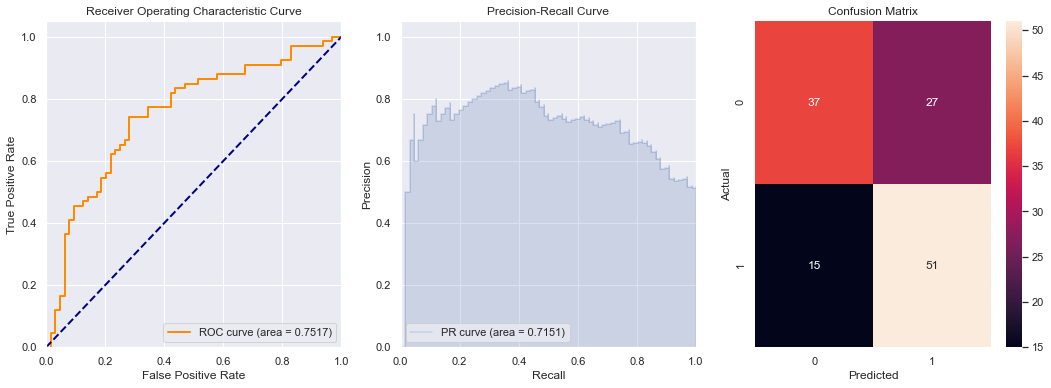

Wall time: 1min 14s


In [104]:
%%time
model_eval.get_binary_classification_plots(spark, data=preds, y_col='y' , 
                                           y_pred_col='yhat', probability_col='probability', threshold=0.5)

In [105]:
feature_cols

['age',
 'last_call_date_diff',
 'last_act_date_diff',
 'last_web_date_diff',
 'target_mean_encodedgender_code']

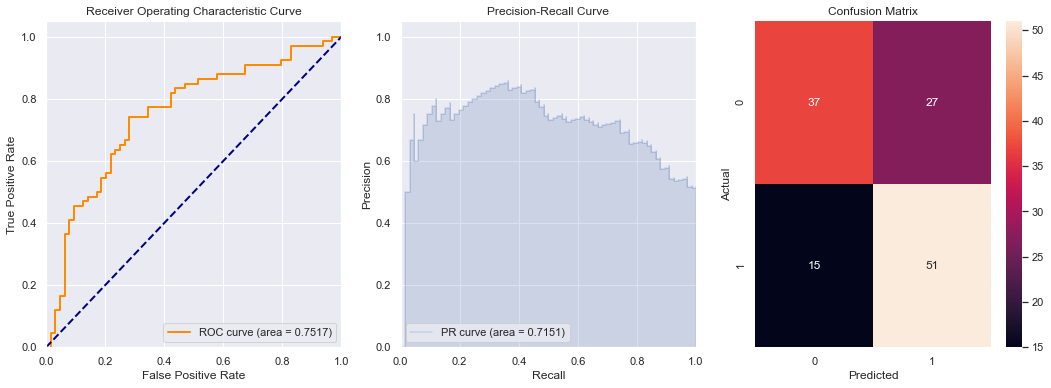

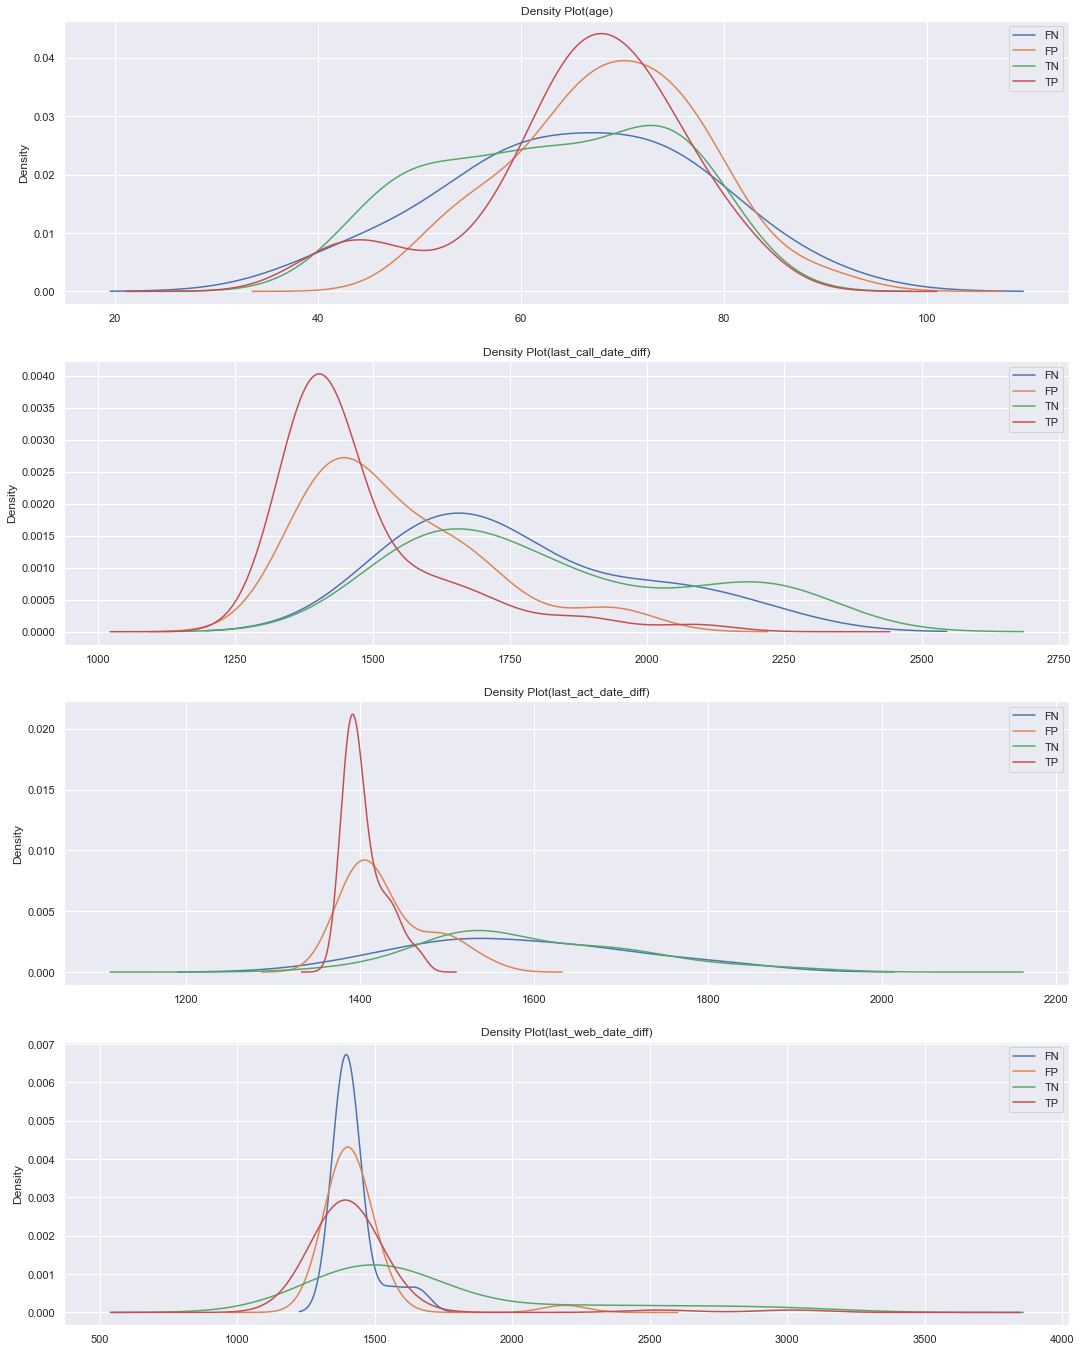

Wall time: 3min 21s


In [106]:
%%time
model_eval.get_binary_classification_plots(spark, data=preds, y_col='y' , y_pred_col='yhat', probability_col='probability'
        , threshold=0.5, feature_cols=['age','last_call_date_diff','last_act_date_diff','last_web_date_diff'], feature_plots=True)

In [107]:
df_sampled_booking.unpersist()

DataFrame[customer_id: bigint, target_var: int]